# 3D Reconstruction using Differentiable Renderer

Guide - Rajashree R
<br>
Ahammed Hani | Dinu D'Silva | Sarath C Ani | Shyamjith M C 

**Make sure that you have chosen the runtime environment as GPU not CPU** <br>
*Choose any one installation*

**Installation - 1 (Less time , not sure about all features , v-0.2.5)**

In [ ]:
!pip install 'torch==1.6.0+cu101' -f https://download.pytorch.org/whl/torch_stable.html
!pip install 'torchvision==0.7.0+cu101' -f https://download.pytorch.org/whl/torch_stable.html
!pip install 'pytorch3d==0.2.5'

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 708.0MB 27kB/s 
ERROR: torchvision 0.9.0+cu101 has requirement torch==1.8.0, but you'll have torch 1.6.0+cu101 which is incompatible.
ERROR: torchtext 0.9.0 has requirement torch==1.8.0, but you'll have torch 1.6.0+cu101 which is incompatible.
  Found existing installation: torch 1.8.0+cu101
    Uninstalling torch-1.8.0+cu101:
      Successfully uninstalled torch-1.8.0+cu101
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 5.9MB 26.8MB/s 
  Found existing installation: torchvision 0.9.0+cu101
    Uninstalling torchvision-0.9.0+cu101:
      Successfully uninstalled torchvision-0.9.0+cu101
     |████████████████████████████████| 20.6MB 160kB/s 
     |████████████████████████████████| 51kB 6.8MB/s 
     |████████████████████████████████| 645kB 38.2MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.4.post20210323-cp37-no

**Installation - 2 (More time(binary building) , sure about all features , v-0.4)**

In [ ]:
!pip install torch torchvision
import os
import sys
import torch
if torch.__version__=='1.6.0+cu101' and sys.platform.startswith('linux'):
    !pip install pytorch3d
else:
    need_pytorch3d=False
    try:
        import pytorch3d
    except ModuleNotFoundError:
        need_pytorch3d=True
    if need_pytorch3d:
        !curl -LO https://github.com/NVIDIA/cub/archive/1.10.0.tar.gz
        !tar xzf 1.10.0.tar.gz
        os.environ["CUB_HOME"] = os.getcwd() + "/cub-1.10.0"
        !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   118  100   118    0     0   1456      0 --:--:-- --:--:-- --:--:--  1456
100  404k    0  404k    0     0  1632k      0 --:--:-- --:--:-- --:--:-- 1632k
  Cloning https://github.com/facebookresearch/pytorch3d.git (to revision stable) to /tmp/pip-req-build-c930omzl
  Running command git clone -q https://github.com/facebookresearch/pytorch3d.git /tmp/pip-req-build-c930omzl
  Running command git checkout -q 3c15a6c2469249c8b90a4f3e41e34350b8051b92
     |████████████████████████████████| 51kB 7.8MB/s 
     |████████████████████████████████| 645kB 41.0MB/s 
  Created wheel for pytorch3d: filename=pytorch3d-0.4.0-cp37-cp37m-linux_x86_64.whl size=23229640 sha256=170002030bced88db17ddbf6647ecc2580cc5a36a4d3f7e5baa7d1a0ca3976b0
  Stored in directory: /tmp/pip-ephem-wheel-cache-2krohzq8/wheels/89/69/08/d864f516508b5d943259c6088baa150eb

**imports**

In [ ]:
### Setup

import os
import sys
import torch
import matplotlib.pyplot as plt
from skimage.io import imread

from pytorch3d.utils import ico_sphere
import numpy as np
from tqdm.notebook import tqdm

# Util function for loading meshes
from pytorch3d.io import load_objs_as_meshes, save_obj

from pytorch3d.loss import (
    chamfer_distance, 
    mesh_edge_loss, 
    mesh_laplacian_smoothing, 
    mesh_normal_consistency,
)

# Data structures and functions for rendering
from pytorch3d.structures import Meshes
from pytorch3d.renderer import (
    look_at_view_transform,
    OpenGLPerspectiveCameras, 
    PointLights, 
    DirectionalLights, 
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    SoftPhongShader,
    SoftSilhouetteShader,
    SoftPhongShader,
    TexturesVertex
)

sys.path.append(os.path.abspath(''))

### CUDA Setup
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 



In [ ]:
### For image plotting - image_grid 

# !wget https://raw.githubusercontent.com/facebookresearch/pytorch3d/master/docs/tutorials/utils/plot_image_grid.py
# from plot_image_grid import image_grid

**Importing images - inputs**


In [ ]:
import cv2

In [ ]:
num_views = 6

elev = torch.Tensor(np.array([0 , 0 , 0 , 0 , 90 , 270]))
azim = torch.Tensor(np.array([-180 , -90 , 90 , 180 , 0 , 0]))

# Place a point light in front of the object. As mentioned above, the front of 
# the cow is facing the -z direction. 
lights = PointLights(device=device, location=[[0.0, 0.0, -3.0]])

# Initialize an OpenGL perspective camera that represents a batch of different 
# viewing angles. All the cameras helper methods support mixed type inputs and 
# broadcasting. So we can view the camera from the a distance of dist=2.7, and 
# then specify elevation and azimuth angles for each viewpoint as tensors. 
R, T = look_at_view_transform(dist=2.7, elev=elev, azim=azim)
cameras = OpenGLPerspectiveCameras(device=device, R=R, T=T)

# We arbitrarily choose one particular view that will be used to visualize 
# results
camera = OpenGLPerspectiveCameras(device=device, R=R[None, 1, ...], 
                                  T=T[None, 1, ...]) 


In [ ]:
img = cv2.imread('input_images/square.jpg' , cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img, (128, 128))
img = img / 255
img_tensor = torch.Tensor(img).to('cuda')
img_tensor

target_images = [img_tensor , img_tensor , img_tensor , img_tensor , img_tensor , img_tensor]

target_silhouette = [img_tensor , img_tensor , img_tensor , img_tensor , img_tensor , img_tensor]

# Our multi-view cow dataset will be represented by these 2 lists of tensors,
# each of length num_views.
# target_rgb = [target_images[i, ..., :3] for i in range(num_views)]
target_cameras = [OpenGLPerspectiveCameras(device=device, R=R[None, i, ...], 
                                           T=T[None, i, ...]) for i in range(num_views)]

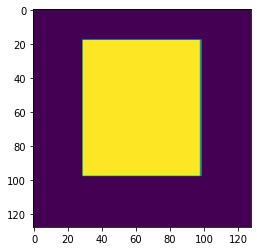

In [ ]:
plt.imshow(img)

**Differentiable Rendering**

In [ ]:
#### For visualizing predictions

def visualize_prediction(mesh , target_image , 
                         renderer = renderer_silhouette , 
                         silhouette = True ,
                         title1 = "" , 
                         title2 = "Target") :
    inds = 3 if silhouette else range(3)
    predicted_images = renderer(mesh)

    plt.figure(figsize = (10,8))
    
    plt.subplot(1, 2, 1)
    plt.title(title1)
    plt.imshow(predicted_images[0, ..., inds].cpu().detach().numpy())
    plt.grid("off")
    plt.axis("off")
    plt.subplot(1, 2, 2)
    plt.title(title2)
    plt.imshow(target_image.cpu().detach().numpy())
    plt.grid("off")
    plt.axis("off")

# src_mesh = ico_sphere(4, device)
# verts_shape = src_mesh.verts_packed().shape
# deform_verts = torch.full(verts_shape, 0.0, device=device, requires_grad=True)
# new_src_mesh = src_mesh.offset_verts(deform_verts)

# visualize_prediction(new_src_mesh , target_silhouette[0] , 
#                      title1 = "Initial mesh - rendered" , 
#                      title2 = "Target image" )

In [ ]:
#### For plotting loss

def plot_losses(losses):
    fig = plt.figure(figsize=(13, 5))
    ax = fig.gca()
    for k, l in losses.items():
        ax.plot(l['values'], label=k + " loss")
    ax.legend(fontsize="16")
    ax.set_xlabel("Iteration", fontsize="16")
    ax.set_ylabel("Loss", fontsize="16")
    ax.set_title("Loss vs iterations", fontsize="16")

In [ ]:
# We initialize the source shape to be a sphere of radius 1.  
src_mesh = ico_sphere(4, device)

In [ ]:
# Create the renderer
sigma = 1e-4
raster_settings_soft = RasterizationSettings(
    image_size=128, 
    blur_radius=np.log(1. / 1e-4 - 1.)*sigma, 
    faces_per_pixel=50, 
    perspective_correct = False
)

# Silhouette renderer 
renderer_silhouette = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=camera, 
        raster_settings=raster_settings_soft
    ),
    shader=SoftSilhouetteShader()
)


In [ ]:
# Number of views to optimize over in each SGD iteration
num_views_per_iteration = 2
# Number of optimization steps
Niter = 200
# Plot period for the losses
plot_period = 20

%matplotlib inline

# Optimize using rendered silhouette image loss, mesh edge loss, mesh normal 
# consistency, and mesh laplacian smoothing
losses = {"silhouette": {"weight": 1.0, "values": []},
          "edge": {"weight": 1.0, "values": []},
          "normal": {"weight": 0.01, "values": []},
          "laplacian": {"weight": 1.0, "values": []},
         }

# Losses to smooth / regularize the mesh shape
def update_mesh_shape_prior_losses(mesh, loss):
    # and (b) the edge length of the predicted mesh
    loss["edge"] = mesh_edge_loss(mesh)
    
    # mesh normal consistency
    loss["normal"] = mesh_normal_consistency(mesh)
    
    # mesh laplacian smoothing
    loss["laplacian"] = mesh_laplacian_smoothing(mesh, method="uniform")

# We will learn to deform the source mesh by offsetting its vertices
# The shape of the deform parameters is equal to the total number of vertices in
# src_mesh
verts_shape = src_mesh.verts_packed().shape
deform_verts = torch.full(verts_shape, 0.0, device=device, requires_grad=True)

# The optimizer
optimizer = torch.optim.SGD([deform_verts], lr=1.0, momentum=0.9)

/usr/local/lib/python3.7/dist-packages/pytorch3d/transforms/transform3d.py:707: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)


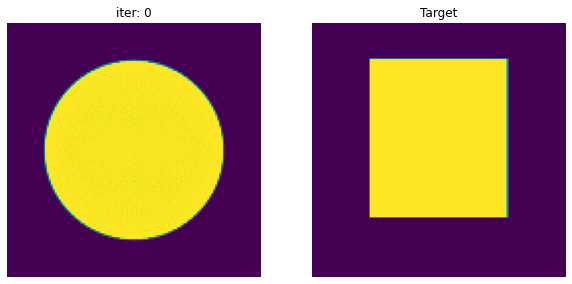

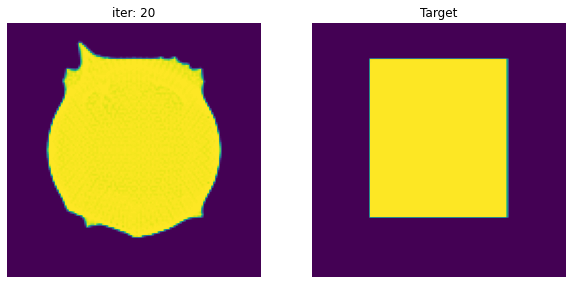

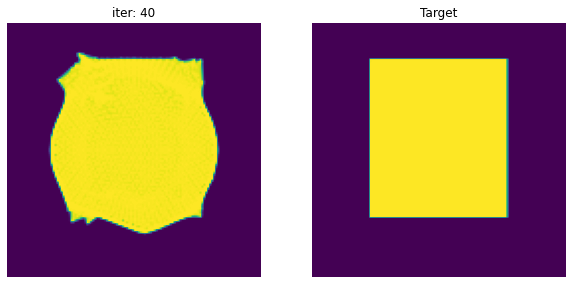

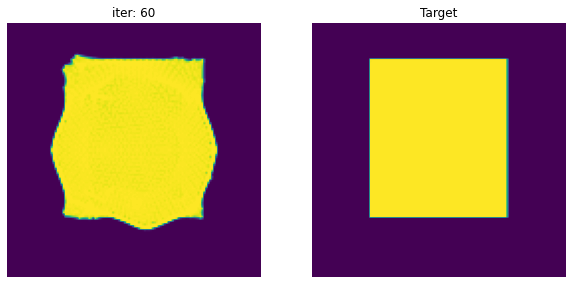

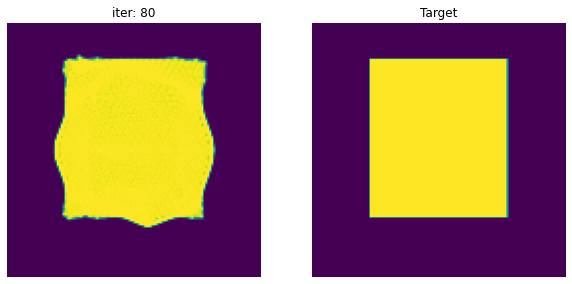

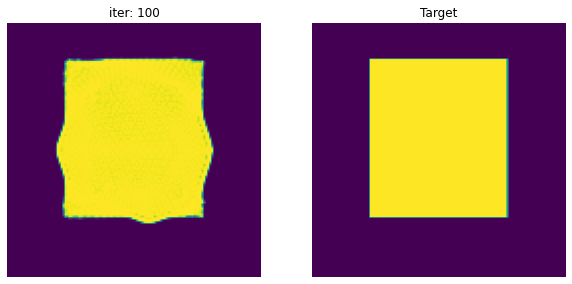

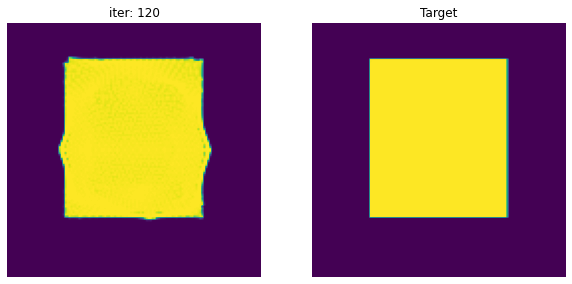

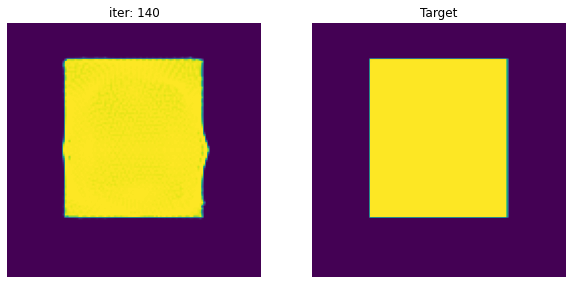

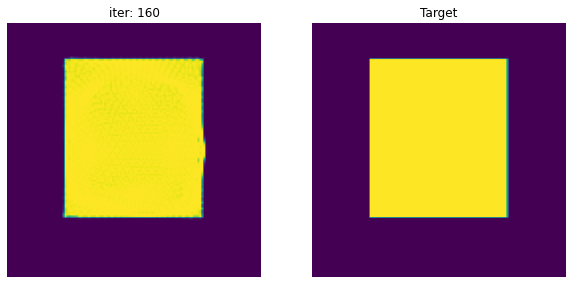

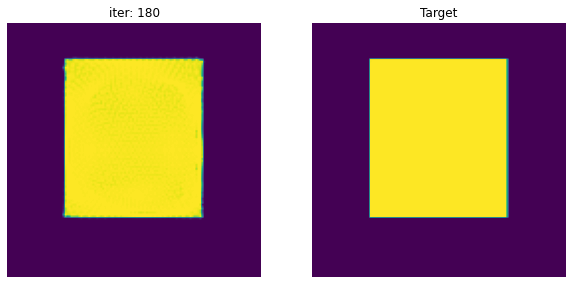

In [ ]:
loop = tqdm(range(Niter))

for i in loop:
    # Initialize optimizer
    optimizer.zero_grad()
    
    # Deform the mesh
    
    new_src_mesh = src_mesh.offset_verts(deform_verts)
    
    # Losses to smooth /regularize the mesh shape
    loss = {k: torch.tensor(0.0, device=device) for k in losses}
    update_mesh_shape_prior_losses(new_src_mesh, loss)
    
    # Compute the average silhouette loss over two random views, as the average 
    # squared L2 distance between the predicted silhouette and the target 
    # silhouette from our dataset
    for j in np.random.permutation(num_views).tolist()[:num_views_per_iteration]:
        images_predicted = renderer_silhouette(new_src_mesh, cameras=target_cameras[j], lights=lights)
        predicted_silhouette = images_predicted[..., 3]
        loss_silhouette = ((predicted_silhouette - target_silhouette[j]) ** 2).mean()
        loss["silhouette"] += loss_silhouette / num_views_per_iteration
    
    # Weighted sum of the losses
    sum_loss = torch.tensor(0.0, device=device)
    for k, l in loss.items():
        sum_loss += l * losses[k]["weight"]
        losses[k]["values"].append(l)
    
    # Print the losses
    loop.set_description("total_loss = %.3f" % sum_loss)
    
    # Plot mesh
    if i % plot_period == 0:
        visualize_prediction(new_src_mesh, title1="iter: %d" % i, silhouette=True,
                             target_image=target_silhouette[1])
        
    # Optimization step
    sum_loss.backward()
    optimizer.step()

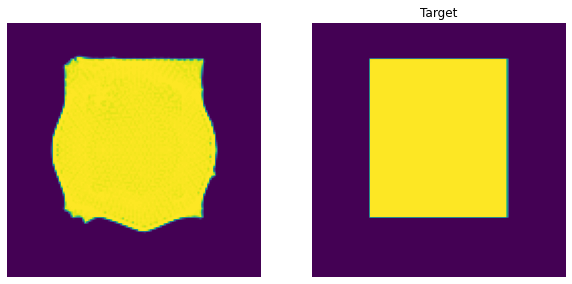

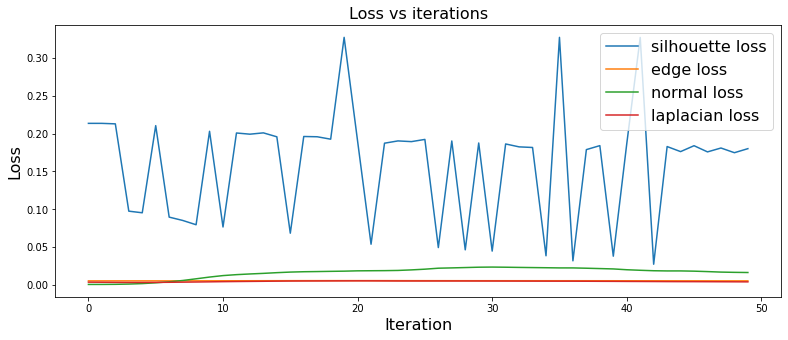

In [ ]:
visualize_prediction(new_src_mesh, silhouette=True, 
                     target_image=target_silhouette[1])
plot_losses(losses)


In [ ]:
mesh = new_src_mesh
verts = mesh.verts_packed()
N = verts.shape[0]
center = verts.mean(0)
scale = max((verts - center).abs().max(0)[0])
mesh.offset_verts_(-center.expand(N, 3))
mesh.scale_verts_((1.0 / float(scale)));


final_verts, final_faces = mesh.get_mesh_verts_faces(0)
final_verts = final_verts * scale + center
final_obj = os.path.join('./', 'sphere.obj')
save_obj(final_obj, final_verts, final_faces)